In [1]:
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor as dtree
from sklearn.ensemble import RandomForestRegressor as rforest
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from statistics import mean, median, stdev
import glob

2024-05-09 13:59:32.211401: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-09 13:59:32.346833: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-09 13:59:33.040014: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def getTimesNew(file):
    timeFile = open(file)
    timeStr = timeFile.readline()
    return(float(timeStr.split("measuredTime ")[1]))

In [3]:
def getMPITime(directory):
    fileName = glob.glob(directory+'/*.mpiP')
    mpipFile = open(str(fileName[0]), 'r')
    with mpipFile as f:
        lines = f.readlines()
    foundBlock = False
    foundHeader = False
    done = False
    timeLines = []
    for i in lines:
        if(done):
            break
        if(foundBlock):
            if(foundHeader):
                if("*" in i):
                    foundBlock = False
                    foundHeader = False
                    done = True
                    break
                else:
                    timeLines.append(i)
        if(foundBlock):
            if("MPITime" in i):
                foundHeader = True
        if("@--- MPI Time (seconds)" in i):
            foundBlock = True
    times = []
    for i in timeLines:
        temp = i.split(" ")
        temp_filtered = []
        for j in temp:
            if(j != ""):
                temp_filtered.append(j)
        times.append(float(temp_filtered[2]))
    return mean(times)

In [4]:
dataset = [["messageSize", "waitTime", "mpiTime", "run"]]

inhib_choices = [(0,0),(2,100000)]
for inhib_proc in inhib_choices:
    for i in range(4):
        fileName = "beatnik_4_4_"+str(inhib_proc[0])+"_"+str(inhib_proc[1])+"_0_"+str(i)+"_time.log"
        timeLogPath = "/home/akhil/Documents/hpcResearch/finalProfilingDataAll/beatnikProfiles/delta/coScheduling/timesCoScheduling/"
        mpiProfilePath = "/home/akhil/Documents/hpcResearch/finalProfilingDataAll/beatnikProfiles/delta/coScheduling/mpipProfiles/"
        runtime = getTimesNew(timeLogPath+fileName)
        mpiTime = getMPITime(mpiProfilePath+"beatnik_4_4_"+str(inhib_proc[0])+"_"+str(inhib_proc[1])+"_0_"+str(i)+"_mpipDump")
        dataset.append([8*1000*inhib_proc[1], 0, mpiTime, i])

In [5]:
dataset_df = pd.DataFrame(dataset)
dataset_df.columns = dataset_df.iloc[0]
dataset_df = dataset_df.drop(dataset_df.index[0])

In [6]:
dataset_df

,messageSize,waitTime,mpiTime,run
1,0,0,3.201875,0
2,0,0,3.201875,1
3,0,0,7.015,2
4,0,0,3.4275,3
5,800000000,0,514.5,0
6,800000000,0,498.25,1
7,800000000,0,247.5,2
8,800000000,0,271.125,3


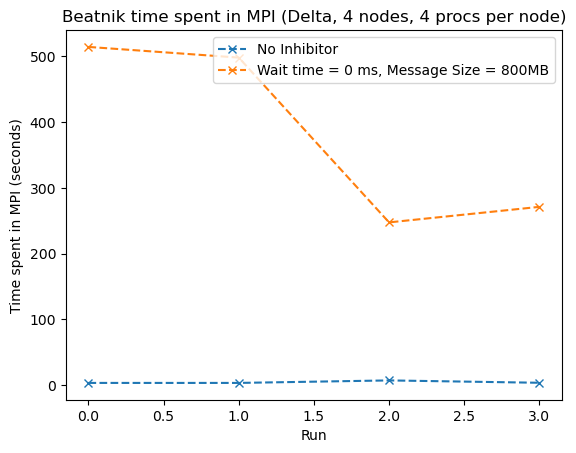

In [7]:
plt.plot(dataset_df.loc[dataset_df["messageSize"] == 0]["run"],
         dataset_df.loc[dataset_df["messageSize"] == 0]["mpiTime"],
                 linestyle='--', marker='x',
                 label="No Inhibitor")

plt.plot(dataset_df.loc[dataset_df["messageSize"] == 800000000]["run"],
         dataset_df.loc[dataset_df["messageSize"] == 800000000]["mpiTime"],
                 linestyle='--', marker='x',
                 label="Wait time = 0 ms, Message Size = 800MB")
plt.xlabel("Run")
plt.ylabel("Time spent in MPI (seconds)")
plt.title("Beatnik time spent in MPI (Delta, 4 nodes, 4 procs per node)")
plt.legend()
plt.show()

In [8]:
dataset = [["nodes", "appProcPerNode", "appProcesses", "inhibProcPerNode", "messageSize", "waitTime", "mpiTime", "stdev"]]

def getFiles(directory):
    files = []
    for f in listdir(directory):
        files.append(join(directory, f))
    return files

nodeChoices = [1, 2]
appProcPerNodeChoices = [1, 4]
inhibProcPerNodeChoices = [2]
msgSizes = [1000, 100000]
waitTimes = [0, 1000]

for node in nodeChoices:
    for appProcPerNode in appProcPerNodeChoices:
        for inhibProcPerNode in inhibProcPerNodeChoices:
            for msgSize in msgSizes:
                for waitTime in waitTimes:
                    times = []
                    for i in range(4):
                        try:
                            fileName = "beatnik_"+str(node)+"_"+str(appProcPerNode)+"_"+str(inhibProcPerNode)+"_"+str(msgSize)+"_"+str(waitTime)+"_"+str(i)+"_time.log"
                            timeLogPath = "/home/akhil/Documents/hpcResearch/finalProfilingDataAll/beatnikProfiles/delta/coScheduling/timesCoScheduling/"
                            mpiProfilePath = "/home/akhil/Documents/hpcResearch/finalProfilingDataAll/beatnikProfiles/delta/coScheduling/mpipProfiles/"
                            runtime = getTimesNew(timeLogPath+fileName)
                            times.append(getMPITime(mpiProfilePath+"beatnik_"+str(node)+"_"+str(appProcPerNode)+"_"+str(inhibProcPerNode)+"_"+str(msgSize)+"_"+str(waitTime)+"_"+str(i)+"_mpipDump"))
                        except:
                            continue
                    if(len(times) > 1):
                        dataset.append([node, appProcPerNode, node*appProcPerNode, inhibProcPerNode, 8*1000*msgSize, waitTime, mean(times), stdev(times)])
            
dataset_df = pd.DataFrame(dataset)
dataset_df.columns = dataset_df.iloc[0]
dataset_df = dataset_df.drop(dataset_df.index[0])
dataset_df = dataset_df.sort_values("appProcesses")


dataset_noInterference = [["nodes", "appProcPerNode", "appProcesses", "mpiTime", "stdev"]]
nodeChoices = [1, 2]
appProcPerNodeChoices = [1, 4]
inhibProcPerNodeChoices = [0]
msgSizes = [1000, 100000]
waitTimes = [0, 1000]

for node in nodeChoices:
    for appProcPerNode in appProcPerNodeChoices:
        for inhibProcPerNode in inhibProcPerNodeChoices:
            times = []
            for msgSize in msgSizes:
                for waitTime in waitTimes:
                    for i in range(4):
                        try:
                            fileName = "beatnik_"+str(node)+"_"+str(appProcPerNode)+"_"+str(inhibProcPerNode)+"_"+str(msgSize)+"_"+str(waitTime)+"_"+str(i)+"_time.log"
                            timeLogPath = "/home/akhil/Documents/hpcResearch/finalProfilingDataAll/beatnikProfiles/delta/coScheduling/timesCoScheduling/"
                            mpiProfilePath = "/home/akhil/Documents/hpcResearch/finalProfilingDataAll/beatnikProfiles/delta/coScheduling/mpipProfiles/"
                            runtime = getTimesNew(timeLogPath+fileName)
                            times.append(getMPITime(mpiProfilePath+"beatnik_"+str(node)+"_"+str(appProcPerNode)+"_"+str(inhibProcPerNode)+"_"+str(msgSize)+"_"+str(waitTime)+"_"+str(i)+"_mpipDump"))
                        except:
                            continue
            if(len(times) > 1):
                dataset_noInterference.append([node, appProcPerNode, node*appProcPerNode, mean(times), stdev(times)])
            
dataset_noInterference_df = pd.DataFrame(dataset_noInterference)
dataset_noInterference_df.columns = dataset_noInterference_df.iloc[0]
dataset_noInterference_df = dataset_noInterference_df.drop(dataset_noInterference_df.index[0])
dataset_noInterference_df = dataset_noInterference_df.sort_values("appProcesses")

In [20]:
dataset_noInterference_df

,nodes,appProcPerNode,appProcesses,mpiTime,stdev
1,1,1,1,0.006009,0.001681
3,2,1,2,3.883875,12.486123
2,1,4,4,1.417109,0.575265
4,2,4,8,2.198437,0.341696


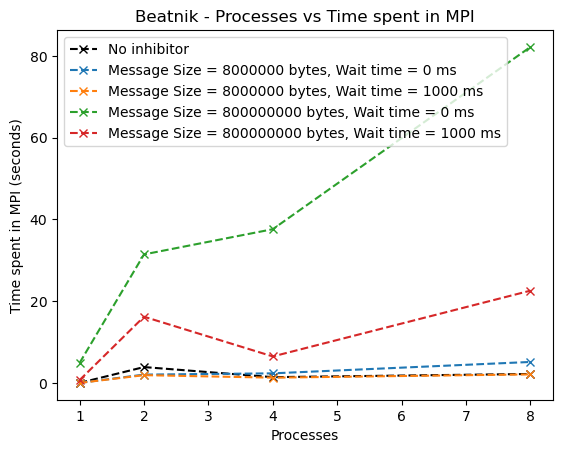

In [11]:
msgSizes_unique = dataset_df["messageSize"].unique()
waitTimes_unique = dataset_df["waitTime"].unique()
plt.plot(dataset_noInterference_df["appProcesses"], dataset_noInterference_df["mpiTime"],
        linestyle='--', marker='x', label="No inhibitor", color="black")

for ms in msgSizes_unique:
    for wt in waitTimes_unique:
        dataset_df_temp = dataset_df.loc[(dataset_df["waitTime"] == wt) & (dataset_df["messageSize"] == ms)]
        plt.plot(dataset_df_temp["appProcesses"], dataset_df_temp["mpiTime"],
                     linestyle='--', marker='x',
                     label="Message Size = "+str(ms)+" bytes, Wait time = "+str(wt)+" ms")

plt.xlabel("Processes")
plt.ylabel("Time spent in MPI (seconds)")
plt.title("Beatnik - Processes vs Time spent in MPI")
plt.legend()
plt.show()

In [22]:
dataset_effectiveBW = [["nodes", "appProcPerNode", "appProcesses", "inhibProcPerNode", "messageSize", "waitTime", "mpiTime", "stdev", "effectiveBW", "slowdown"]]
for i in dataset_df.iloc:
    wt = i["waitTime"]/1000
    messageSize = i["messageSize"]
    if(wt > 0):
        effectiveBW = (i["inhibProcPerNode"]*i["nodes"]*messageSize*4)/wt
        temp_dataset = dataset_noInterference_df.loc[(dataset_noInterference_df["nodes"] == i["nodes"])&
                                                (dataset_noInterference_df["appProcesses"] == i["appProcesses"])&
                                                (dataset_noInterference_df["appProcPerNode"] == i["appProcPerNode"])]
        originalMPITime = temp_dataset.iloc[0]["mpiTime"]
        slowdown = i["mpiTime"]/originalMPITime
        dataset_effectiveBW.append([i["nodes"], i["appProcPerNode"], i["appProcesses"], i["inhibProcPerNode"],
                                    i["messageSize"],
                                    i["waitTime"], i["mpiTime"], i["stdev"], float(effectiveBW), float(slowdown)])
dataset_effectiveBW_df = pd.DataFrame(dataset_effectiveBW)
dataset_effectiveBW_df.columns = dataset_effectiveBW_df.iloc[0]
dataset_effectiveBW_df = dataset_effectiveBW_df.drop(dataset_effectiveBW_df.index[0])
dataset_effectiveBW_df = dataset_effectiveBW_df.sort_values("effectiveBW")
dataset_effectiveBW_df

,nodes,appProcPerNode,appProcesses,inhibProcPerNode,messageSize,waitTime,mpiTime,stdev,effectiveBW,slowdown
1,1,1,1,2,8000000,1000,0.005522,0.001658,64000000.0,0.918981
5,1,4,4,2,8000000,1000,1.291875,0.140563,64000000.0,0.911627
3,2,1,2,2,8000000,1000,1.906,1.973083,128000000.0,0.490747
7,2,4,8,2,8000000,1000,2.095937,0.354257,128000000.0,0.953376
2,1,1,1,2,800000000,1000,0.691,0.243237,6400000000.0,114.986999
6,1,4,4,2,800000000,1000,6.4825,2.134464,6400000000.0,4.574453
4,2,1,2,2,800000000,1000,16.2,2.137756,12800000000.0,4.171092
8,2,4,8,2,800000000,1000,22.575,0.99828,12800000000.0,10.268657


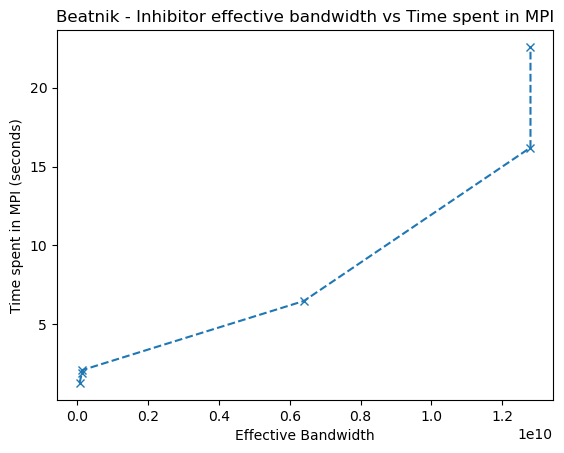

In [30]:
msgSizes_unique = dataset_effectiveBW_df["messageSize"].unique()

# plt.plot(dataset_effectiveBW_df["effectiveBW"], dataset_effectiveBW_df["mpiTime"],
#              linestyle='--', marker='x')


plt.plot(dataset_effectiveBW_df.loc[dataset_effectiveBW_df["appProcesses"] > 1]["effectiveBW"],
         dataset_effectiveBW_df.loc[dataset_effectiveBW_df["appProcesses"] > 1]["mpiTime"],
             linestyle='--', marker='x')


# plt.plot(dataset_effectiveBW_df.loc[dataset_effectiveBW_df["appProcesses"] == 1]["effectiveBW"],
#          dataset_effectiveBW_df.loc[dataset_effectiveBW_df["appProcesses"] == 1]["mpiTime"],
#              linestyle='--', marker='x', color='red')
# plt.plot(dataset_effectiveBW_df["effectiveBW"], dataset_effectiveBW_df["mpiTime"],
#              linestyle='--', marker='x', color='blue')


plt.xlabel("Effective Bandwidth")
plt.ylabel("Time spent in MPI (seconds)")
plt.title("Beatnik - Inhibitor effective bandwidth vs Time spent in MPI")
plt.show()

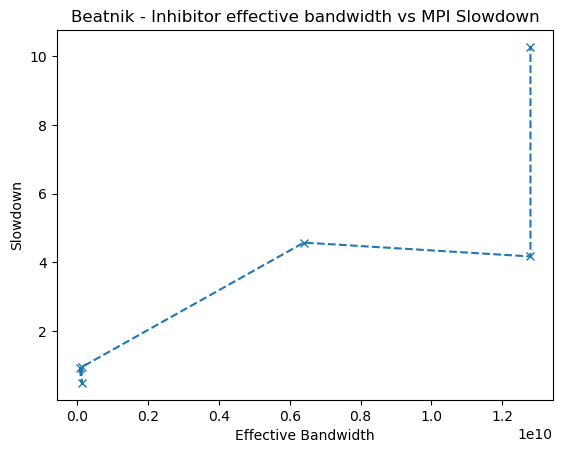

In [27]:
msgSizes_unique = dataset_effectiveBW_df["messageSize"].unique()

# plt.plot(dataset_effectiveBW_df["effectiveBW"], dataset_effectiveBW_df["slowdown"],
#              linestyle='--', marker='x')

plt.plot(dataset_effectiveBW_df.loc[dataset_effectiveBW_df["appProcesses"] > 1]["effectiveBW"],
         dataset_effectiveBW_df.loc[dataset_effectiveBW_df["appProcesses"] > 1]["slowdown"],
             linestyle='--', marker='x')



plt.xlabel("Effective Bandwidth")
plt.ylabel("Slowdown")
plt.title("Beatnik - Inhibitor effective bandwidth vs MPI Slowdown")
plt.show()